In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
ticker_symbol = 'AAPL'

def fetch_stock_data(ticker_symbol, start_date, end_date, interval = '1d'):
    ticker_data = yf.Ticker(ticker_symbol)
    stock_data = ticker_data.history(start=start_date, end=end_date, interval=interval)
    return stock_data

stock_data = fetch_stock_data('AAPL', '2023-10-01', '2024-04-30')

In [3]:
close_prices = stock_data[['Close']]
close_prices = close_prices.reset_index(drop=True)
print(close_prices.info())
print(close_prices.head())
print(close_prices.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   145 non-null    float64
dtypes: float64(1)
memory usage: 1.3 KB
None
        Close
0  171.897980
1  170.562393
2  171.808945
3  173.045654
4  175.598129
          Close
140  165.549530
141  167.652374
142  168.515335
143  167.930099
144  172.096130


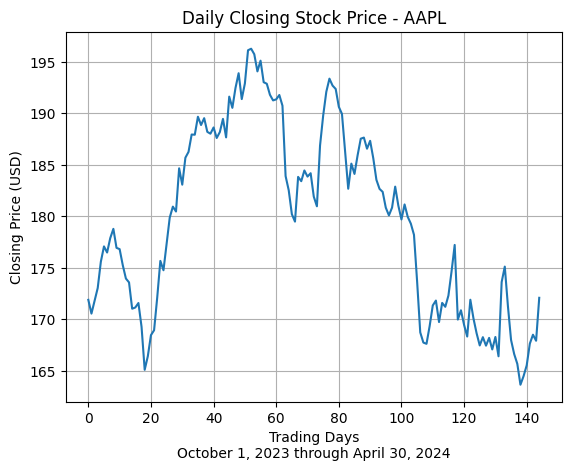

In [4]:
plt.subplots()
plt.plot(close_prices)
plt.xlabel('Trading Days\n'
           'October 1, 2023 through April 30, 2024')
plt.ylabel('Closing Price (USD)')
plt.title('Daily Closing Stock Price - AAPL')
plt.grid()
plt.show()

In [5]:
max_close = close_prices['Close'].max()
min_close = close_prices['Close'].min()
print(max_close)
print(min_close)

196.25657653808594
163.66490173339844


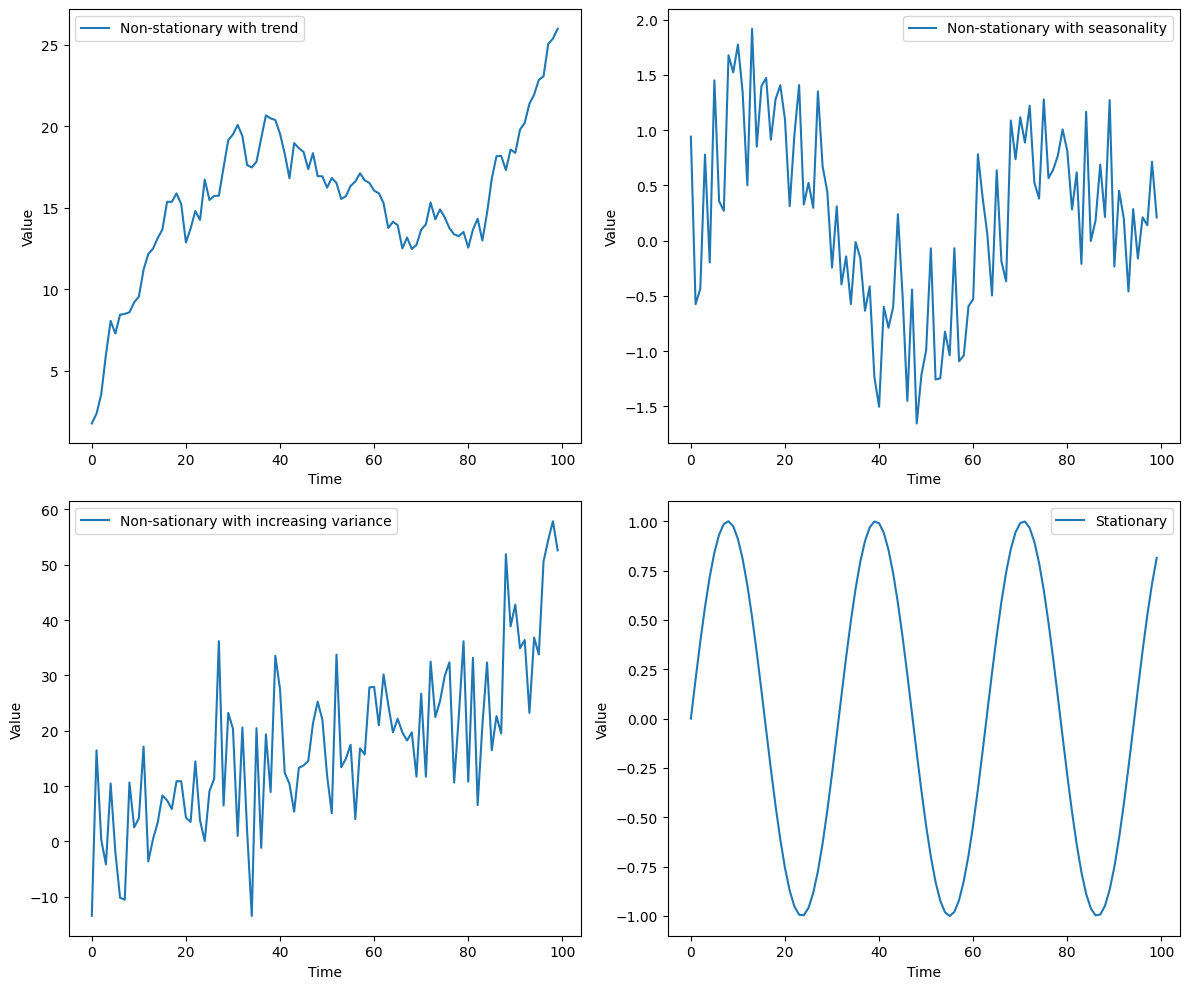

In [6]:
np.random.seed(0)

plt.figure(figsize=(12,10))
plt.subplot(221)
t = np.arange(0,100)
data1 = np.cumsum(np.random.randn(100)) + np.linspace(0, 20, 100)
plt.plot(t, data1, label='Non-stationary with trend')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(222)
data2 = np.sin(t/10) + np.random.randn(100) * 0.5
plt.plot(t, data2, label='Non-stationary with seasonality')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(223)
data3 = np.cumsum(np.random.randn(100)) + np.linspace(0, 50, 100) + np.random.randn(100) * 10
plt.plot(t, data3, label='Non-sationary with increasing variance')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(224)
data4 = np.sin(t/5)
plt.plot(t, data4, label='Stationary')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


p-value: 0.5761112011848228


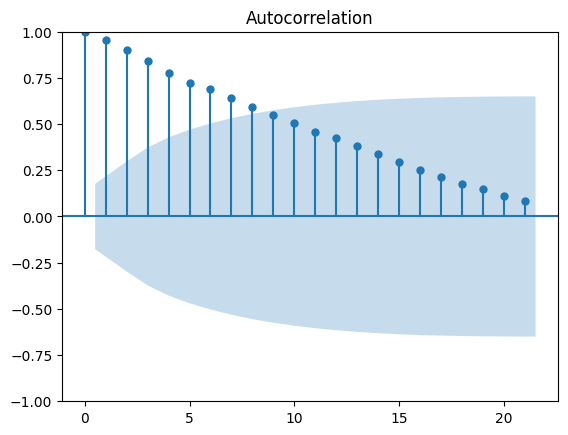

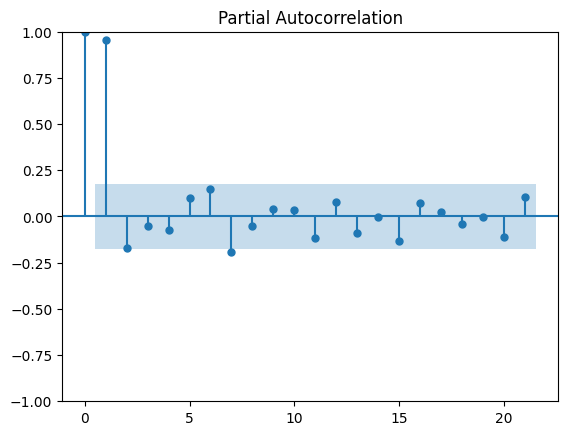

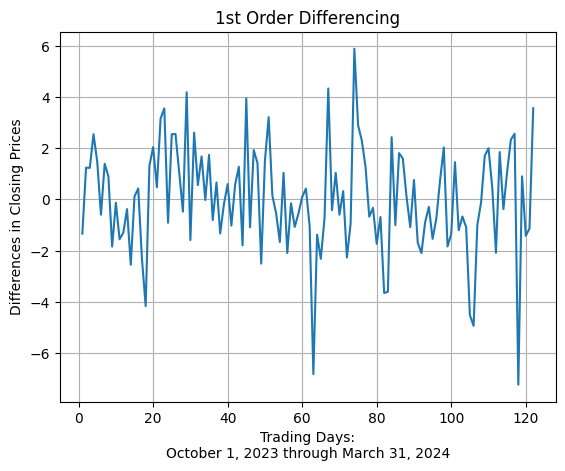

In [7]:
bln_msk = (close_prices.index < len(close_prices) - 22)
train = close_prices[bln_msk].copy()
test = close_prices[~bln_msk].copy()

acf = plot_acf(train)
pacf = plot_pacf(train)

adf_test = adfuller(train)
print('p-value:', adf_test[1])

train_diff = train.diff().dropna()

train_diff.plot()
plt.xlabel('Trading Days:\n'
              'October 1, 2023 through March 31, 2024')
plt.ylabel('Differences in Closing Prices')
plt.title('1st Order Differencing')
plt.legend().set_visible(False)
plt.grid()
plt.show()

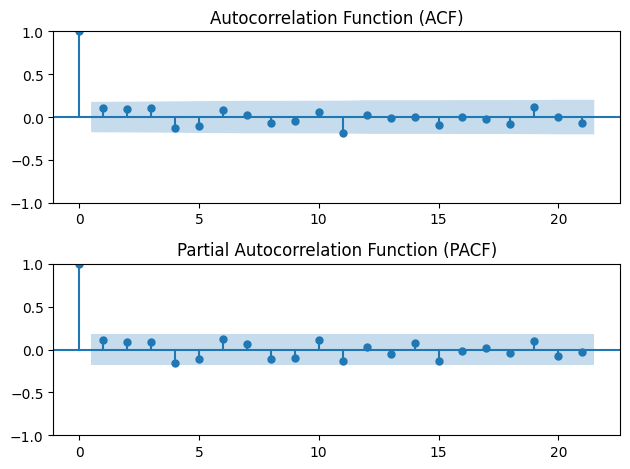

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_acf(train_diff, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(train_diff, ax = ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

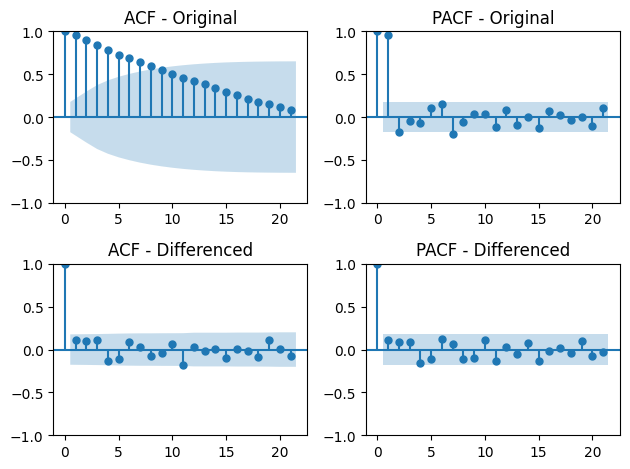

In [10]:
fig, axes = plt.subplots(2, 2)
plot_acf(train, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Original')
plot_pacf(train, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Original')
plot_acf(train_diff, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Differenced')
plot_pacf(train_diff, ax=axes[1,1])
axes[1, 1].set_title('PACF - Differenced')
plt.tight_layout()
plt.show()

In [11]:
adf_test_diff = adfuller(train_diff)
print('p-value:', adf_test_diff[1])

p-value: 1.2487431450793421e-16


In [12]:
model = ARIMA(train, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  123
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -263.015
Date:                Sun, 07 Dec 2025   AIC                            530.031
Time:                        09:34:13   BIC                            535.639
Sample:                             0   HQIC                           532.308
                                - 123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1084      0.091      1.196      0.232      -0.069       0.286
sigma2         4.3656      0.434     10.068      0.000       3.516       5.215
Ljung-Box (L1) (Q):                   0.01   Jarque-

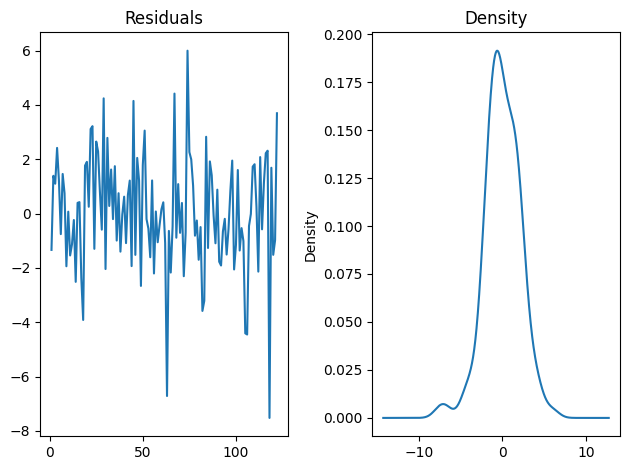

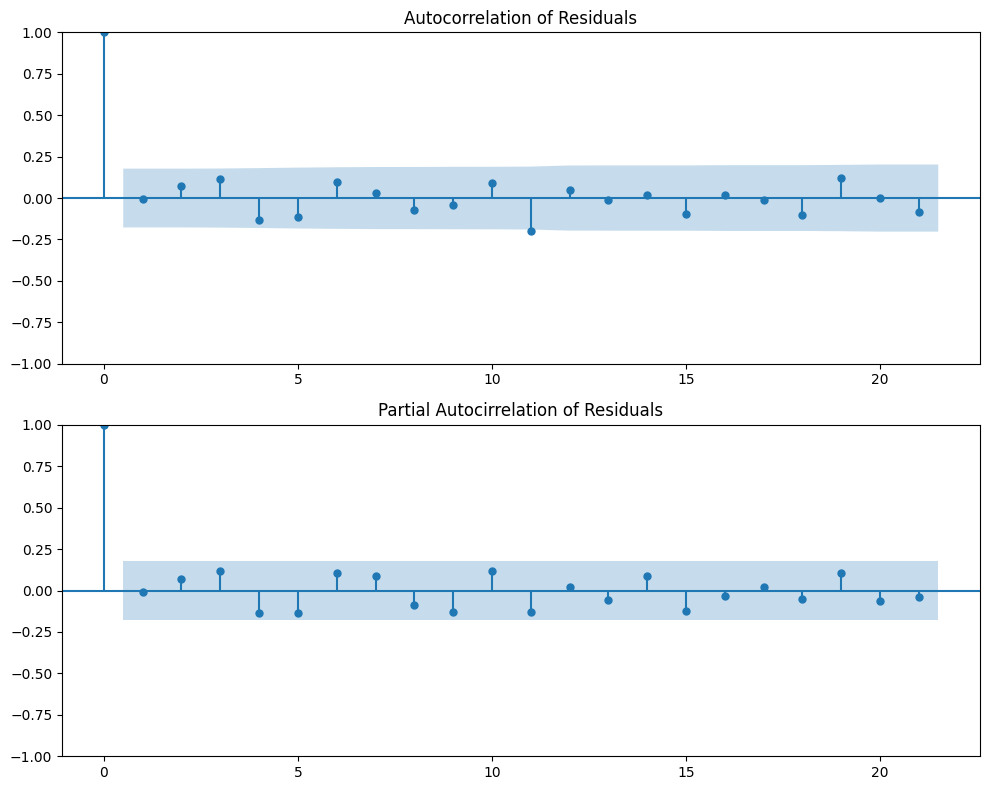

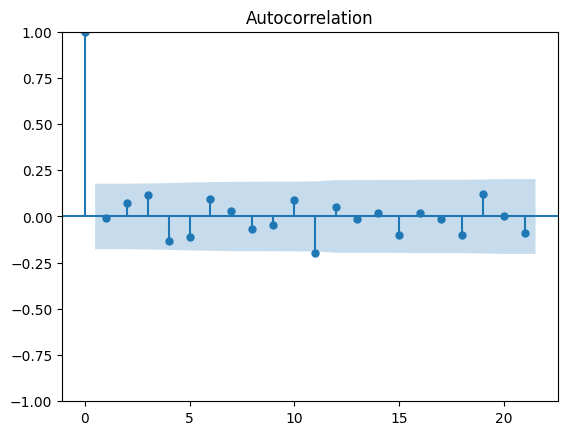

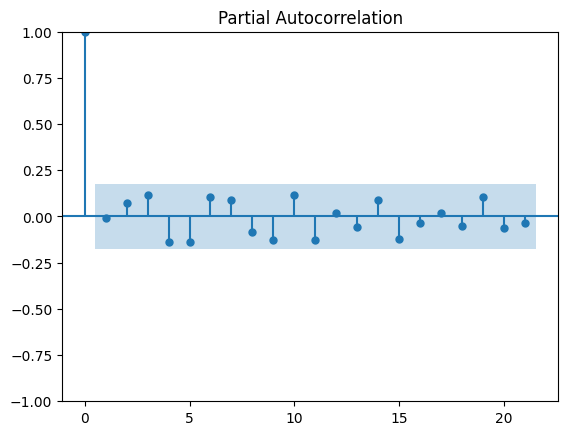

In [13]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax=ax[0])
residuals.plot(title = 'Density', kind='kde', ax = ax[1])
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
plot_acf(residuals, ax=ax1)
ax1.set_title('Autocorrelation of Residuals')
plot_pacf(residuals, ax=ax2)
ax2.set_title('Partial Autocirrelation of Residuals')
plt.tight_layout()
plt.show()
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

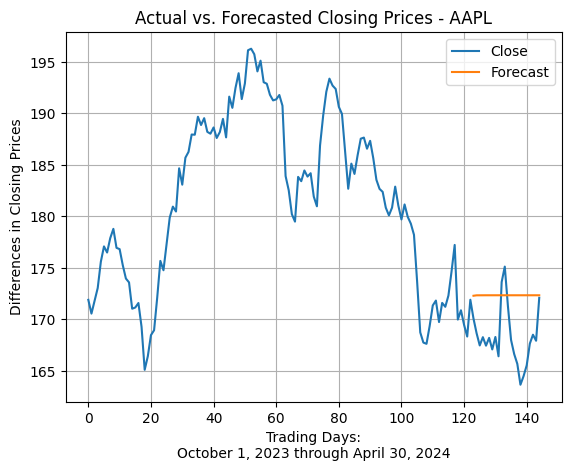

In [14]:
forecast_test = model_fit.forecast(len(test))
close_prices['Forecast'] = [None] * len(train) + list(forecast_test)
close_prices.plot()
plt.xlabel('Trading Days:\n'
           'October 1, 2023 through April 30, 2024')
plt.ylabel('Differences in Closing Prices')
plt.title('Actual vs. Forecasted Closing Prices - AAPL')
plt.grid()
plt.show()

In [15]:
last_22_days = close_prices.tail(22)
mean_closing_price = last_22_days['Close'].mean()
print(mean_closing_price)

168.28403958407316


                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Close   No. Observations:                  123
Model:             SimpleExpSmoothing   SSE                            538.870
Optimized:                       True   AIC                            185.707
Trend:                           None   BIC                            191.331
Seasonal:                        None   AICC                           186.046
Seasonal Periods:                None   Date:                 Sun, 07 Dec 2025
Box-Cox:                        False   Time:                         09:44:06
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              171.89798                

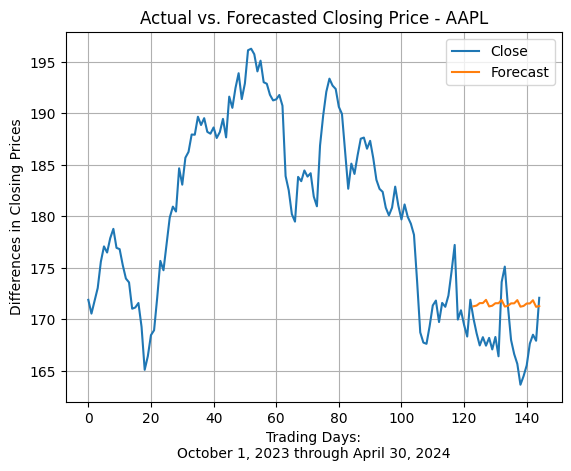

171.22287315717625
171.8951374986619
171.4930353302807


In [16]:
ses_model = SimpleExpSmoothing(train).fit()
print(ses_model.summary())

des_model = ExponentialSmoothing(train, trend='add').fit()
print(des_model.summary())

hw_model = ExponentialSmoothing(train,
                                trend = 'add',
                                seasonal = 'add',
                                seasonal_periods = 5).fit()

print(f"AIC: {hw_model.aic}")
print(f"BIC: {hw_model.bic}")
forecast_test = hw_model.forecast(len(test))
close_prices['Forecast'] = [None] * len(train) + list(forecast_test)
close_prices.plot()
plt.xlabel('Trading Days:\n'
           'October 1, 2023 through April 30, 2024')
plt.ylabel('Differences in Closing Prices')
plt.title('Actual vs. Forecasted Closing Price - AAPL')
plt.grid()
plt.show()

minimum_value = np.min(forecast_test)
print(minimum_value)
maximum_value = np.max(forecast_test)
print(maximum_value)
mean_value = np.mean(forecast_test)
print(mean_value)